In [4]:
import os
import h5py

data_dir='/data/scratch/jiayin/milan'
aggr_time='hour' # "hour"
file_name = "milan_{}_T_N_5.h5".format(
            'min' if aggr_time is None else aggr_time)
# file_name = "data_git_version.h5"
filePath = os.path.join(data_dir, file_name)
print(filePath)

if not os.path.exists(filePath):
    raise FileNotFoundError("file {} not found".format(filePath))


/data/scratch/jiayin/milan/milan_hour_T_N_5.h5


In [12]:
# 虽然
import pandas as pd
import numpy as np

with h5py.File(filePath, 'r') as f:
    print("Keys in HDF5 file:", list(f.keys()))
    # 读取数据集
    data = f['data'][:]
    time_data = f['time'][:]
    # 如果时间数据是字节类型，需要解码
    time_data = [t.decode('utf-8') if isinstance(t, bytes) else t for t in time_data]

print('data shape: ', data.shape)
# 查找 NaN 或 Inf 的位置
nan_positions = np.where(np.isnan(data))
print(f"NaN的位置: {nan_positions}")
unique_elements, counts = np.unique(nan_positions[0], return_counts=True)

print('time_data (list) length: ', len(time_data))
print('time data: ', time_data[:72])
print('data', data[:72,4142,1])

# 将时间数据转换为 pandas 的 DatetimeIndex, times里就包含各种时间特征
times = pd.to_datetime(time_data, format='%Y-%m-%d %H:%M:%S')
print("Total unique timestamps:", times.nunique())


Keys in HDF5 file: ['data', 'time']
data shape:  (1488, 10000, 5)
NaN的位置: (array([  52,   52,   52, ..., 1487, 1487, 1487]), array([5238, 5238, 5238, ..., 5338, 5338, 5338]), array([0, 1, 2, ..., 2, 3, 4]))
time_data (list) length:  1488
time data:  ['2013-10-31 23:00:00', '2013-11-01 00:00:00', '2013-11-01 01:00:00', '2013-11-01 02:00:00', '2013-11-01 03:00:00', '2013-11-01 04:00:00', '2013-11-01 05:00:00', '2013-11-01 06:00:00', '2013-11-01 07:00:00', '2013-11-01 08:00:00', '2013-11-01 09:00:00', '2013-11-01 10:00:00', '2013-11-01 11:00:00', '2013-11-01 12:00:00', '2013-11-01 13:00:00', '2013-11-01 14:00:00', '2013-11-01 15:00:00', '2013-11-01 16:00:00', '2013-11-01 17:00:00', '2013-11-01 18:00:00', '2013-11-01 19:00:00', '2013-11-01 20:00:00', '2013-11-01 21:00:00', '2013-11-01 22:00:00', '2013-11-01 23:00:00', '2013-11-02 00:00:00', '2013-11-02 01:00:00', '2013-11-02 02:00:00', '2013-11-02 03:00:00', '2013-11-02 04:00:00', '2013-11-02 05:00:00', '2013-11-02 06:00:00', '2013-11-02 0

In [27]:
# 如果你想检查是否是一天一天排列，可以计算相邻日期之间的日期部分的差值
# 先提取日期部分
dates = times.normalize()  # 将时间归一化到午夜
diff = dates.to_series().diff().dropna()

# 查看所有不同的日期差值
print("Unique date differences:", diff.unique())

# 统计每种差值出现的次数
diff_counts = diff.value_counts().sort_index()
print("\nDate differences counts:")
for delta, count in diff_counts.items():
    print(f"{delta}: {count} times")

Unique date differences: [             0 86400000000000]

Date differences counts:
0 days 00:00:00: 8865 times
1 days 00:00:00: 62 times


In [29]:
# 检查时间间隔是否连续
import pandas as pd
with h5py.File(filePath, 'r') as f:
    # 假设 time 数据集存储的是字符串或字节型时间戳
    time_data = f['time'][:]  # 读取全部数据

# 如果时间数据以字节形式存储，需要先解码（假设是UTF-8编码）
time_data = [t.decode('utf-8') if isinstance(t, bytes) else t for t in time_data]

# 将时间数据转换为 pandas datetime 对象
times = pd.to_datetime(time_data, format='%Y-%m-%d %H:%M:%S')

# 将 DatetimeIndex 转换为 Series 并计算相邻时间差（Timedelta）
time_series = times.to_series()
time_diff = time_series.diff().dropna()

# 使用 value_counts 统计每个时间差出现的次数
diff_counts = time_diff.value_counts().sort_index()
print("\n各连续时间间隔及其出现次数：")
for td, count in diff_counts.items():
    # td 是 Timedelta 对象，直接转换为字符串即可获得易读格式
    print(f"{str(td)} : {count} 次")

# 定义要查找的时间间隔
gap = pd.Timedelta("1 days 00:10:00")

# 筛选出那些间隔等于 gap 的位置
gap_positions = time_diff[time_diff == gap]

print("出现 1 days 00:10:00 的时间间隔的位置和对应的时间戳：")
for idx, gap_value in gap_positions.items():
    # idx 对应当前时间戳，前一个时间戳为 time_series.loc[idx] 的前一行
    # 使用索引的 .shift() 或直接利用 index 获取前一个值：
    prev_idx = time_series.index.get_loc(idx) - 1
    if prev_idx >= 0:
        prev_time = time_series.iloc[prev_idx]
    else:
        prev_time = None
    print(f"Gap from {prev_time} to {idx} (间隔: {gap_value})")


各连续时间间隔及其出现次数：
0 days 00:10:00 : 8927 次
出现 1 days 00:10:00 的时间间隔的位置和对应的时间戳：


In [13]:
# 检查初始txt，时间间隔最小是10min
# 文件名对应的时间是混乱的，但是最后的h5文件的时间是正确排列的，还好

data_dir='/data/scratch/jiayin'
file_name = 'sms-call-internet-mi-2013-11-02.txt'
path = os.path.join(data_dir, file_name)
data = pd.read_txt(path, header=0, index_col=0)
data.reset_index(inplace=True)  # 重置索引，将 'cellid' 恢复为普通列
data['time'] = pd.to_datetime(data['time'], unit='ms')  # 原时间格式为ms

# 查看最早和最晚的时间
earliest_time = data['time'].min()
latest_time = data['time'].max()

print(f"最早的时间: {earliest_time}")
print(f"最晚的时间: {latest_time}")

# 查看数据其中5行
print(data[10:15])



最早的时间: 2013-11-17 23:00:00
最晚的时间: 2013-11-18 22:50:00
    cellid                time  countrycode     smsin    smsout  callin  \
10       1 2013-11-17 23:50:00           39  0.054601  0.081901  0.0273   
11       1 2013-11-18 00:00:00            0  0.054601       NaN     NaN   
12       1 2013-11-18 00:00:00           39  0.105713  0.078412  0.0273   
13       1 2013-11-18 00:10:00           33       NaN  0.027300     NaN   
14       1 2013-11-18 00:10:00           39  0.001787  0.001787     NaN   

     callout  internet  
10       NaN  7.657518  
11       NaN       NaN  
12  0.054601  6.924802  
13       NaN       NaN  
14  0.027300  7.543973  


In [ ]:
import matplotlib.pyplot as plt
# 国家代码列表示这个电话/短信发生的国家。从统计结果看，最多的国家代码是 39（意大利），其次是 0（可能表示国内或未记录国家信息），再是 33（法国）、49（德国）和 46（瑞典）。似乎没有提供什么信息，故舍弃了。

# 统计各 countrycode 的频次
counts = data['countrycode'].value_counts()
# 输出频次最高的 countrycode 和出现次数
print("出现最多的 countrycode：")
print(counts.head(5))

# 设置图形大小
plt.figure(figsize=(12, 6))
# 绘制柱状图
counts.plot(kind='bar')

plt.xlabel("Country Code")
plt.ylabel("Frequency")
plt.title("Frequency of Each Country Code")
plt.tight_layout()
plt.show()

In [15]:
import os

# 新文件存储目录
new_data_dir = '/data/scratch/jiayin/milan'

# 获取所有txt文件，并按文件名排序
txt_files = sorted([f for f in os.listdir(new_data_dir) if f.endswith('.txt')])

# 输出txt文件的总数
print(f"总共有 {len(txt_files)} 个txt文件。")

# 打印所有txt文件名
for i, file_name in enumerate(txt_files, start=1):
    print(f"{i}. {file_name}")

总共有 59 个csv文件。
1. sms-call-internet-mi-2013-11-01.csv
2. sms-call-internet-mi-2013-11-02.csv
3. sms-call-internet-mi-2013-11-03.csv
4. sms-call-internet-mi-2013-11-04.csv
5. sms-call-internet-mi-2013-11-05.csv
6. sms-call-internet-mi-2013-11-06.csv
7. sms-call-internet-mi-2013-11-07.csv
8. sms-call-internet-mi-2013-11-08.csv
9. sms-call-internet-mi-2013-11-09.csv
10. sms-call-internet-mi-2013-11-10.csv
11. sms-call-internet-mi-2013-11-12.csv
12. sms-call-internet-mi-2013-11-13.csv
13. sms-call-internet-mi-2013-11-14.csv
14. sms-call-internet-mi-2013-11-15.csv
15. sms-call-internet-mi-2013-11-16.csv
16. sms-call-internet-mi-2013-11-18.csv
17. sms-call-internet-mi-2013-11-19.csv
18. sms-call-internet-mi-2013-11-20.csv
19. sms-call-internet-mi-2013-11-21.csv
20. sms-call-internet-mi-2013-11-22.csv
21. sms-call-internet-mi-2013-11-23.csv
22. sms-call-internet-mi-2013-11-24.csv
23. sms-call-internet-mi-2013-11-25.csv
24. sms-call-internet-mi-2013-11-26.csv
25. sms-call-internet-mi-2013-11-2

In [22]:
import os
import requests

# 目标目录
new_data_dir = '/data/scratch/jiayin/milan'

# 创建目录（如果不存在）
os.makedirs(new_data_dir, exist_ok=True)

# 文件和对应的contentUrl
files_info = [
    {"name":"sms-call-internet-mi-2013-11-01.txt", "url": "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EGZHFV/AKDGBV"},
    {"name": "sms-call-internet-mi-2013-11-11.txt", "url": "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EGZHFV/RPEY0M"},
    # {"name": "sms-call-internet-mi-2013-11-17.txt", "url": "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EGZHFV/55XYHB"},
    # {"name": "sms-call-internet-mi-2013-12-09.txt", "url": "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EGZHFV/ZKH5WK"},
    # {"name": "sms-call-internet-mi-2013-12-24.txt", "url": "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EGZHFV/E3QKMV"}
]

# 下载并保存文件
for file_info in files_info:
    file_name = file_info["name"]
    url = file_info["url"]

    # 请求文件
    response = requests.get(url)

    # 如果请求成功，则保存文件
    if response.status_code == 200:
        file_path = os.path.join(new_data_dir, file_name)
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f"文件 {file_name} 已下载并保存在 {new_data_dir}")
    else:
        print(f"下载 {file_name} 失败，状态码：{response.status_code}")

文件 sms-call-internet-mi-2013-11-01.txt 已下载并保存在 /data/scratch/jiayin/milan
文件 sms-call-internet-mi-2013-11-11.txt 已下载并保存在 /data/scratch/jiayin/milan


crawled_feature.csv already exists in /data/scratch/jiayin/milan
milan_hour_T_N_5.h5 already exists in /data/scratch/jiayin/milan
crawled_feature.csv already exists in /data/scratch/jiayin/milan
milan_hour_T_N_5.h5 already exists in /data/scratch/jiayin/milan
loaded meta of shape: (4, 100, 100) 
Loading Milan data...
setup data shape:  (1248, 1, 100, 100)


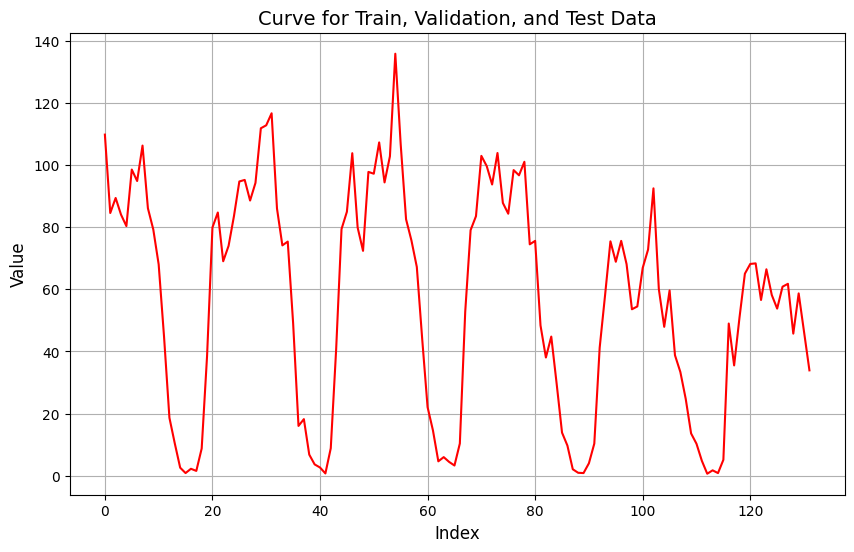

In [8]:
from datasets.Milan import MilanDataset
import matplotlib.pyplot as plt
import numpy as np

milan_dataset = MilanDataset(format='mywat',
                            batch_size=32,
                            aggr_time='hour',
                            grid_range=(1, 100, 1, 100),
                            time_range='all',
                            tele_column='sms',
                            normalize=False,
                            close_len = 6, # => Xc (stgcn)
                            period_len = 0, # => Xp (stgcn)
                            trend_len = 0, # => Xt (stgcn)
                            )
milan_dataset.prepare_data()
milan_dataset.setup()

data_train = milan_dataset.milan_train # ndarray [7142,1,100,100]
data_val = milan_dataset.milan_val # ndarray [898,1,100,100]
data_test = milan_dataset.milan_test # ndarray [900,1,100,100]

data_all = np.concatenate((data_train, data_val, data_test), axis=0)

# 查找 data[:, 4142, 0] 中大于 150 的元素的位置
# positions = np.where(data_all[:, 0, 41, 42] > 40)
# print(f"Positions where value is greater than 150: {positions}")

# 假设 data_train, data_val, data_test 已经是 ndarray
# 提取数据的某一部分 (0:24*42, 0, 12, 12)
train_data = data_train[0:147, 0, 41, 42]
val_data = data_val[0:147, 0, 41, 42]
test_data = data_test[:, 0, 41, 42]

# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 绘制 train, val, test 数据的曲线
# plt.plot(train_data, label='Train Data', color='blue', linestyle='-')
# plt.plot(val_data, label='Validation Data', color='green', linestyle='-')
plt.plot(test_data, label='Test Data', color='red', linestyle='-')

# plt.plot(data_all[:,0,41,42])
# 添加标题和标签
plt.title('Curve for Train, Validation, and Test Data', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value', fontsize=12)

# 显示图例
# plt.legend()

# 显示图形
plt.grid(True)
plt.show()
# 小时级别，异常值位置集中出现在2013-12-24 - 2014-01-01

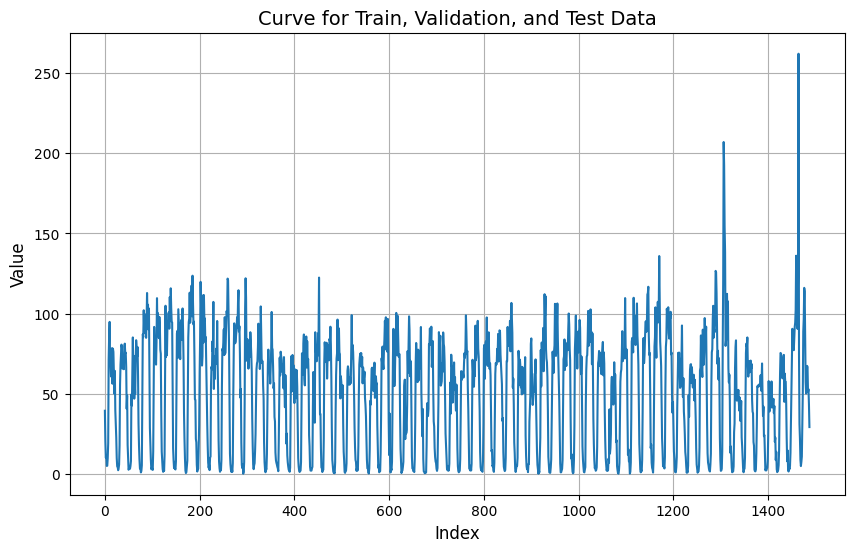

In [15]:
import os
import h5py
import matplotlib.pyplot as plt

data_dir='/data/scratch/jiayin/milan'
file_name = "milan_hour_T_N_5_interp.h5"
filePath = os.path.join(data_dir, file_name)
with h5py.File(filePath, 'r') as f:
    # 假设 time 数据集存储的是字符串或字节型时间戳
    data = f['data'][:]  # 读取全部数据


# 1488, 10000, 3
# 假设 data_train, data_val, data_test 已经是 ndarray
# 提取数据的某一部分 (0:24*42, 0, 12, 12)
train_data = data[0:147, 4142, 2]
val_data = data[1190:1190+148, 4142, 2]
test_data = data[1190+149:1487, 4142, 2]

# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 绘制 train, val, test 数据的曲线
# plt.plot(train_data, label='Train Data', color='blue', linestyle='-')
# plt.plot(val_data, label='Validation Data', color='green', linestyle='-')
# plt.plot(test_data, label='Test Data', color='red', linestyle='-')
plt.plot(data[:,4142,0])

# 添加标题和标签
plt.title('Curve for Train, Validation, and Test Data', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value', fontsize=12)

# 显示图例
# plt.legend()

# 显示图形
plt.grid(True)
plt.show()

crawled_feature.csv already exists in /data/scratch/jiayin/milan
milan_10min_T_N_5.h5 already exists in /data/scratch/jiayin/milan
crawled_feature.csv already exists in /data/scratch/jiayin/milan
milan_10min_T_N_5.h5 already exists in /data/scratch/jiayin/milan
loaded meta of shape: (4, 20, 20) 
Loading Milan data...
setup data shape:  (7488, 1, 20, 20)
1.0
1.0
1.0


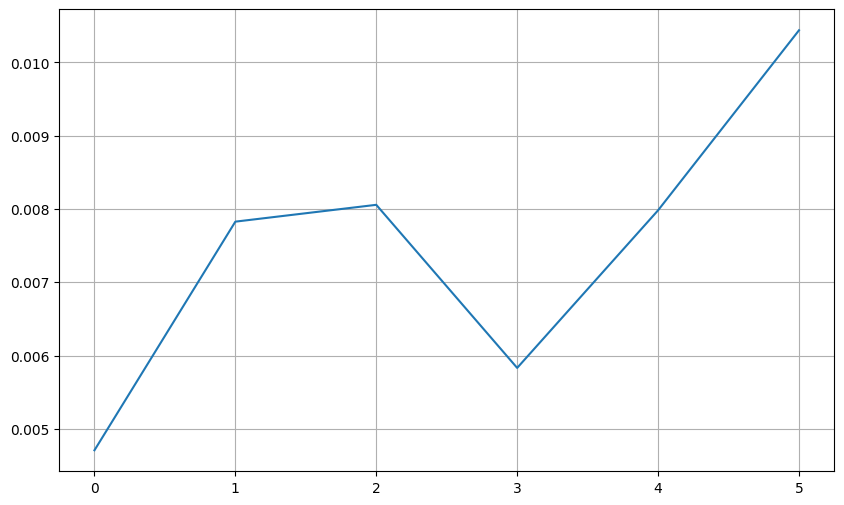

In [2]:
from datasets.MilanFG import MilanFG
import matplotlib.pyplot as plt

milan_dataset = MilanFG(format='mywat',
                            batch_size=32,
                            aggr_time='10min',
                            time_range='all',
                            tele_column='sms',
                            close_len = 6, # => Xc (stgcn)
                            period_len = 0, # => Xp (stgcn)
                            trend_len = 0, # => Xt (stgcn)
                            pred_len=3
                            )
milan_dataset.prepare_data()
milan_dataset.setup()

time_fea = milan_dataset.times_feature
print(time_fea[:,6].max())
print(time_fea[:,7].max())
print(time_fea[:,8].max())

# 获取 train_dataloader
train_dl = milan_dataset.train_dataloader()
val_dl = milan_dataset.val_dataloader()
test_dl = milan_dataset.test_dataloader()

# 获取一个 batch，查看 X 和 Y 的维度
batch = next(iter(train_dl))

# 这里假设 _get_dataset 返回的数据结构为 (X, Y)
X, Y = batch

plt.figure(figsize=(10, 6))
plt.plot(X[0,126,:])
plt.grid(True)
plt.show()




In [4]:
import numpy as np
from shapely.geometry import Polygon

# 定义六个cell的坐标
cell_1 = [(9.0114910478323, 45.35880131440966), (9.014491488013135, 45.35880097314403),
          (9.0144909480813, 45.35668565341486), (9.011490619692509, 45.356685994655464)]

cell_2 = [(9.014491488013135, 45.35880097314403), (9.017491928134044, 45.358800553060284),
          (9.017491276410173, 45.35668523336193), (9.0144909480813, 45.35668565341486)]

cell_3 = [(9.017491928134044, 45.358800553060284), (9.02049236818262, 45.35880005415845),
          (9.020491604666724, 45.356684734496675), (9.017491276410173, 45.35668523336193)]

cell_4 = [(9.02049236818262, 45.35880005415845), (9.023492808146456, 45.35879947643852),
          (9.023491932838542, 45.35668415681913), (9.020491604666724, 45.356684734496675)]

cell_5 = [(9.023492808146456, 45.35879947643852), (9.026493248013145, 45.35879881990051),
          (9.02649226091323, 45.35668350032926), (9.023491932838542, 45.35668415681913)]

cell_6 = [(9.026493248013145, 45.35879881990051), (9.029493687770275, 45.35879808454441),
          (9.029492588878375, 45.35668276502711), (9.02649226091323, 45.35668350032926)]

# 将坐标数据转换为Shapely Polygon对象
cells = [cell_1, cell_2, cell_3, cell_4, cell_5, cell_6]

# 用于存储每个区域的面积和是否为矩形的判断
areas = []
is_rectangle = []

for cell in cells:
    polygon = Polygon(cell)
    areas.append(polygon.area)
    # 检查是否是矩形
    is_rectangle.append(polygon.is_valid and len(polygon.exterior.coords) == 5)

# 输出结果
print("Areas of cells:", areas)
print("Are all cells rectangles?", all(is_rectangle))

Areas of cells: [6.346772275481034e-06, 6.346772150063796e-06, 6.346771998693207e-06, 6.346771821344179e-06, 6.3467716180261235e-06, 6.346771388732764e-06]
Are all cells rectangles? True


In [6]:
import h5py

# 加载生成的HDF5文件
file_path = '/data/scratch/jiayin/milan/milano-grid-coordinates.h5'

with h5py.File(file_path, 'r') as f:
    # 打印HDF5文件的所有键
    print("Keys in the HDF5 file:", list(f.keys()))

    # 获取 'cell_vertices' 和 'centroids' 数据集
    cell_vertices = f['cell_vertices'][:]
    centroids = f['centroids'][:]

    # 打印数据集的基本信息
    print("Shape of 'cell_vertices':", cell_vertices.shape)
    print("Shape of 'centroids':", centroids.shape)

    # 打印前几个样本以检查内容
    print("First 5 cell vertices:\n", cell_vertices[:5])
    print("First 5 centroids:\n", centroids[:5])

Keys in the HDF5 file: ['cell_vertices', 'centroids']
Shape of 'cell_vertices': (10000, 5, 2)
Shape of 'centroids': (10000, 2)
First 5 cell vertices:
 [[[ 9.01149105 45.35880131]
  [ 9.01449149 45.35880097]
  [ 9.01449095 45.35668565]
  [ 9.01149062 45.35668599]
  [ 9.01149105 45.35880131]]

 [[ 9.01449149 45.35880097]
  [ 9.01749193 45.35880055]
  [ 9.01749128 45.35668523]
  [ 9.01449095 45.35668565]
  [ 9.01449149 45.35880097]]

 [[ 9.01749193 45.35880055]
  [ 9.02049237 45.35880005]
  [ 9.0204916  45.35668473]
  [ 9.01749128 45.35668523]
  [ 9.01749193 45.35880055]]

 [[ 9.02049237 45.35880005]
  [ 9.02349281 45.35879948]
  [ 9.02349193 45.35668416]
  [ 9.0204916  45.35668473]
  [ 9.02049237 45.35880005]]

 [[ 9.02349281 45.35879948]
  [ 9.02649325 45.35879882]
  [ 9.02649226 45.3566835 ]
  [ 9.02349193 45.35668416]
  [ 9.02349281 45.35879948]]]
First 5 centroids:
 [[ 9.01299103 45.35774349]
 [ 9.01599141 45.35774311]
 [ 9.01899179 45.35774265]
 [ 9.02199218 45.35774211]
 [ 9.024992

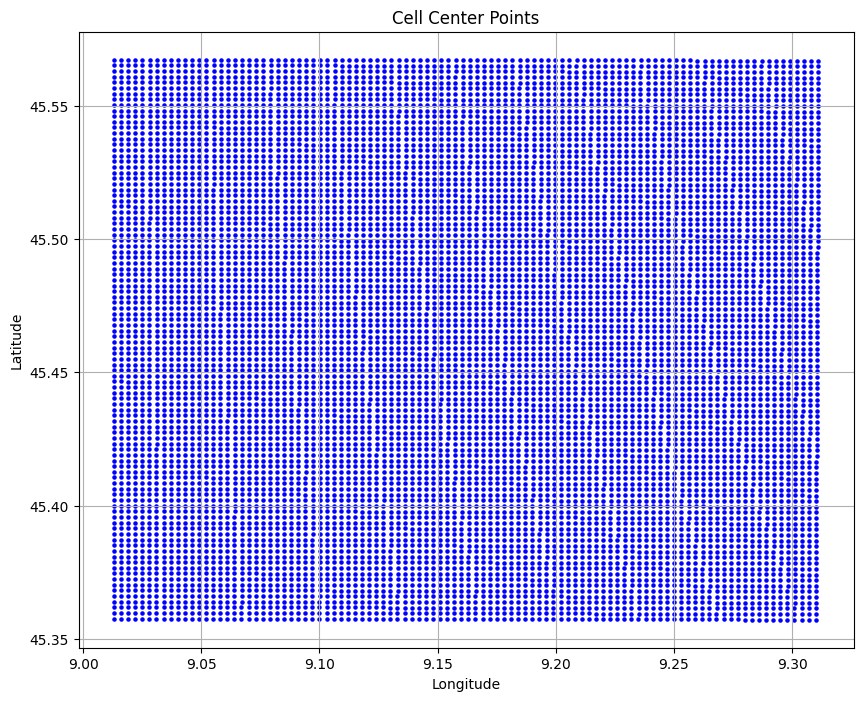

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 加载存储cell顶点的h5文件
file_path = '/data/scratch/jiayin/milan/milano-grid-coordinates.h5'
with h5py.File(file_path, 'r') as f:
    # 获取每个cell的顶点数据，形状为 (10000, 5, 2)
    cell_vertices = f['cell_vertices'][:]

# 计算每个cell的中心点
center_points = []

for vertices in cell_vertices:
    # 获取前四个顶点（忽略重复的最后一个点）
    coords = vertices[:4]  # 前四个顶点
    # 计算每个矩形的中心点坐标：取四个顶点的平均值
    center_x = np.mean(coords[:, 0])
    center_y = np.mean(coords[:, 1])
    center_points.append([center_x, center_y])

# 将中心点列表转换为numpy数组
center_points = np.array(center_points)

# 绘制所有cell的中心点
plt.figure(figsize=(10, 8))
plt.scatter(center_points[:, 0], center_points[:, 1], c='blue', s=5, marker='o')
plt.title('Cell Center Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [3]:
# 检查rank
from datasets.Milan import MilanDataset
dm = MilanDataset(
    format='informer',
    batch_size=32,
    close_len=6,
    period_len=0,
    trend_len=0,
    pred_len=3,
    normalize=True,
    aggr_time='hour',
    time_range='all',
)
dm.prepare_data()
dm.setup()

# 获取 train_dataloader
train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()
test_dl = dm.test_dataloader()


H5 file already exists at /data/scratch/jiayin/milan/milan_hour_T_N_5.h5
Loaded complete data shape: (1248, 1, 20, 20)


AttributeError: 'MilanDataset' object has no attribute 'meta'